# Desarrollo M2

In [74]:
%load_ext autoreload
%autoreload 2

import os
import sys
project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import pandas as pd
# import seaborn
# seaborn.set_context(context="talk")

from torch.utils.data import DataLoader

from src.data.dataset import lc_dataset
from src.models.model import periodicTransformer
from src.visualization.plots import plot_periodic
from src.data.curve_generator import random_periodic_sin_mix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of src.models.model failed: Traceback (most recent call last):
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/agonzalez/projects/el7006/Projecto-EL7006/src/models/model.py", line 6, in <module>
    from src.utils import SaveBestModel
ImportError: cannot import name 'SaveBestModel' from 'src.utils' (/home/agonzalez/projects/el7006/

## Objetivos

- [ ] Cambiar el codificador posicional actual (discreto) a uno continuo, puede ser el de T. Sousa o O. Pimentel
- [X] Probar con un conjunto más amplio de clases (curvas sinteticas), por lo que vi tienen dos clases por ahora, traten de extender el problema a almenos 4
- [ ] Realizar pruebas con curvas dobladas (en fase), curvas no dobladas y otras con fase aumentada (esto es simplemente entregar dos fases o tres, una tras la otra)
- [ ] Observar como se comportan los pesos de atención en el caso de series periodicas vs no periodicas, para esto recomiendo que dentro de las 4 clases periodicas que vayan a generar integren una quinta que sea no periodica, sería interesante ver como clasifica esta serie no periodica si el modelo fue entrenado con solo curvas periodicas
- [X] Esto es un poco más libre, pero generar algunas figuras como matrices de confusión, curvas roc, curvas de perdida o accuracy en el tiempo, visualización de el espacio de caracteristicas etc..

## Clasificación de 5 clases

### Generaciónd de datos

In [75]:
train_data = lc_dataset()
train_data.add_curves('sinmix', N=800, seq_len=200, min_period=0.5, max_period=2, label=0)
train_data.add_curves('sinmix', N=800, seq_len=200, min_period=5, max_period=10, label=1)
train_data.add_curves('sawtooth', N=800, seq_len=200, min_period=1.5, max_period=4, label=2)
train_data.add_curves('square', N=800, seq_len=200, min_period=2, max_period=8, label=3)
train_data.add_curves('gauss', N=800, seq_len=200, min_period=2, max_period=8, label=4)

val_data = lc_dataset(seed=127)
val_data.add_curves('sinmix', N=300, seq_len=200, min_period=0.5, max_period=2, label=0)
val_data.add_curves('sinmix', N=300, seq_len=200, min_period=5, max_period=10, label=1)
val_data.add_curves('sawtooth', N=300, seq_len=200, min_period=1.5, max_period=4, label=2)
val_data.add_curves('square', N=300, seq_len=200, min_period=2, max_period=8, label=3)
val_data.add_curves('gauss', N=300, seq_len=200, min_period=2, max_period=8, label=4)

### Visualización del dataset

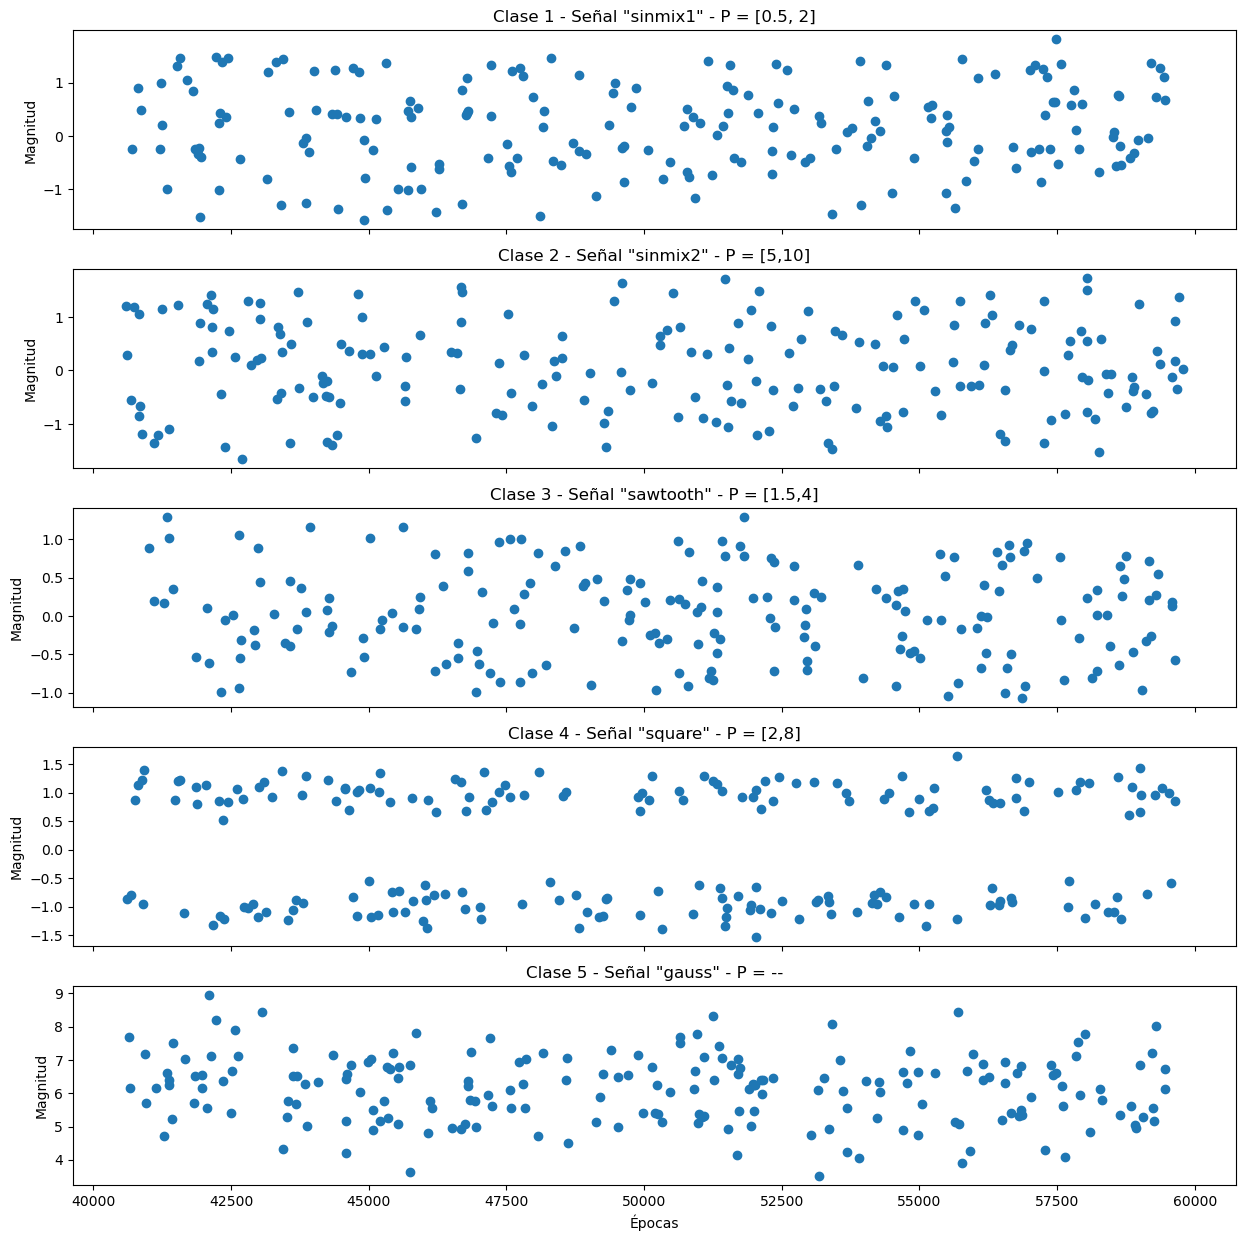

In [76]:
fig, ax = plt.subplots(5, figsize=(15,15), sharex=True)

for label in range(5):
    temp_data = train_data.to_df().loc[train_data.to_df()['label'] == label].iloc[0].copy()
    ax[label].scatter(temp_data.mjd, temp_data.mag)
    ax[label].set_ylabel('Magnitud')
ax[0].set_title('Clase 1 - Señal "sinmix1" - P = [0.5, 2]')
ax[1].set_title('Clase 2 - Señal "sinmix2" - P = [5,10]')
ax[2].set_title('Clase 3 - Señal "sawtooth" - P = [1.5,4]')
ax[3].set_title('Clase 4 - Señal "square" - P = [2,8]')
ax[4].set_title('Clase 5 - Señal "gauss" - P = --')
plt.xlabel('Épocas')
plt.show()

### Clasificación

#### DataLoaders

In [77]:
batch_size = 64


train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            pin_memory=True,
                            num_workers=16,
                            shuffle=True)

val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16,
                        shuffle=True)                


#### Generación del modelo

In [78]:
n_classes = 5
n_blocks = 6

tmp_model = periodicTransformer(n_classes=n_classes, N=n_blocks, d_model=200, d_ff=2048, h=8, dropout=0.1)

/home/agonzalez/projects/el7006/Projecto-EL7006/src/models/model.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if p.dim() > 1:


#### Training

In [80]:
loss, val_loss = tmp_model.fit(train_loader, val_loader, 20)

Epoch: 0 - Train loss: 0.12581424415111542 - Val loss: 0.2665315866470337 - Val acc: 0.8571428656578064
Epoch: 1 - Train loss: 0.034803371876478195 - Val loss: 1.2299749851226807 - Val acc: 0.6785714030265808
Epoch: 2 - Train loss: 0.028753841295838356 - Val loss: 0.4173493981361389 - Val acc: 0.8571428656578064
Epoch: 3 - Train loss: 0.004322448745369911 - Val loss: 1.6096723079681396 - Val acc: 0.6428571343421936
Epoch: 4 - Train loss: 0.11028077453374863 - Val loss: 0.7361037135124207 - Val acc: 0.75
Epoch: 5 - Train loss: 0.00646489392966032 - Val loss: 1.0884138345718384 - Val acc: 0.75
Epoch: 6 - Train loss: 0.013273156248033047 - Val loss: 1.4856446981430054 - Val acc: 0.6785714030265808
Epoch: 7 - Train loss: 0.02694421261548996 - Val loss: 1.6589710712432861 - Val acc: 0.6785714030265808
Epoch: 8 - Train loss: 0.0593685545027256 - Val loss: 0.9844619035720825 - Val acc: 0.8214285969734192
Epoch: 9 - Train loss: 0.11532777547836304 - Val loss: 1.7401750087738037 - Val acc: 0.60

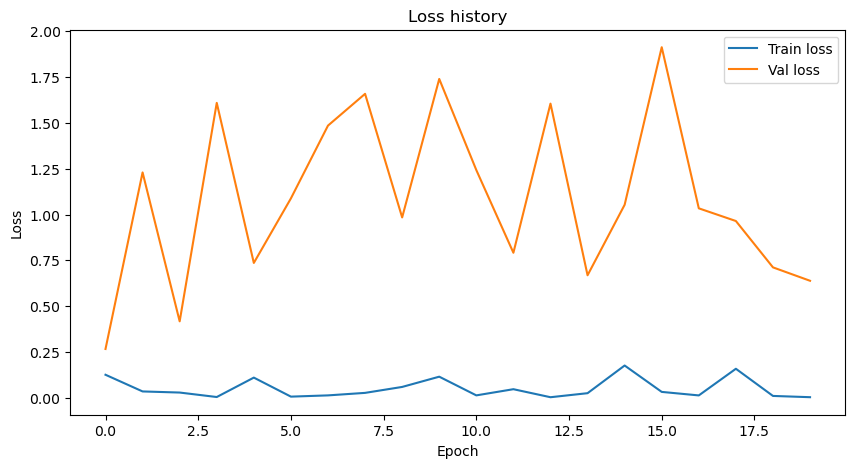

In [81]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(loss)
ax.plot(val_loss)
ax.set_title('Loss history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train loss', 'Val loss'])
plt.show()

#### Testing

In [82]:
test_data = lc_dataset(seed=10)
test_data.add_curves('sinmix', N=200, seq_len=200, min_period=0.5, max_period=2, label=0)
test_data.add_curves('sinmix', N=200, seq_len=200, min_period=5, max_period=10, label=1)
test_data.add_curves('sawtooth', N=200, seq_len=200, min_period=1.5, max_period=4, label=2)
test_data.add_curves('square', N=200, seq_len=200, min_period=2, max_period=8, label=3)
test_data.add_curves('gauss', N=200, seq_len=200, min_period=2, max_period=8, label=4)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16,
                        shuffle=True)    

_, test_predictions = tmp_model.test(test_loader)
test_predictions = np.array(test_predictions)

Test batch acc: 0.6875
Test batch acc: 0.8125
Test batch acc: 0.78125
Test batch acc: 0.796875
Test batch acc: 0.796875
Test batch acc: 0.796875
Test batch acc: 0.78125
Test batch acc: 0.703125
Test batch acc: 0.75
Test batch acc: 0.765625
Test batch acc: 0.765625
Test batch acc: 0.75
Test batch acc: 0.8125
Test batch acc: 0.828125
Test batch acc: 0.71875
Test batch acc: 0.7749999761581421
Test avg acc: 0.7701171636581421


#### Matriz de confusión

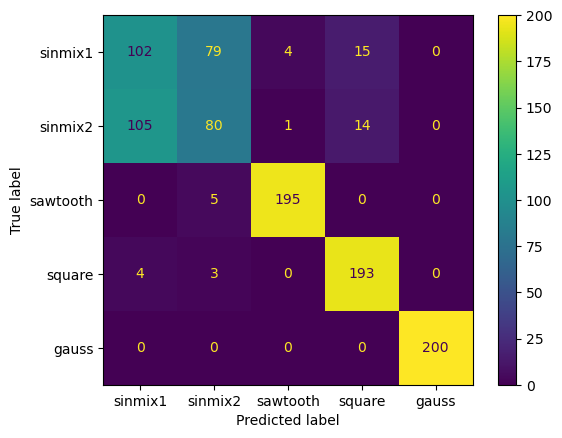

In [83]:
cm = confusion_matrix(
                    test_predictions[:,0],
                    test_predictions[:,1])
disp = ConfusionMatrixDisplay(
                            confusion_matrix=cm,
                            display_labels=[
                                'sinmix1',
                                'sinmix2',
                                'sawtooth',
                                'square',
                                'gauss'])
disp.plot()
plt.show()

#### Otras métricas

In [84]:
print(
    classification_report(
        test_predictions[:,0],
        test_predictions[:,1],
        target_names=['sinmix1', 'sinmix2', 'sawtooth', 'square','gauss']
        )
        )

              precision    recall  f1-score   support

     sinmix1       0.48      0.51      0.50       200
     sinmix2       0.48      0.40      0.44       200
    sawtooth       0.97      0.97      0.97       200
      square       0.87      0.96      0.91       200
       gauss       1.00      1.00      1.00       200

    accuracy                           0.77      1000
   macro avg       0.76      0.77      0.76      1000
weighted avg       0.76      0.77      0.76      1000



## Propuesta a futuro

- Datos con tiempos en distintos intervalos
- Datos con distintos rangos de magnitudes
- Analizar como afecta desbalance